In [1]:
library(ggplot2)
library(dplyr)
library(plot3D)
library(latex2exp)
library(pracma)

Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.2.2"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'plot3D' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"


Jest to Gaussian Plume

Wzięłam to z tego linku:

https://faculty.washington.edu/markbenj/CEE357/CEE%20357%20air%20dispersion%20models.pdf

x,y,z to współrzędne gdzie oś OX jest wyznaczona jako kierunek wiatru

Póki co wszędzie przyjęłam $Q=10\frac{g}{s}$ ale to też trzeba będzie przemyśleć.

In [2]:
data_wind <- read.csv('wind_clouds.csv')
colnames(data_wind) <- c('time','clouds','sun', 'speed', 'direction')

In [6]:
find_category <- function(speed, sun, clouds){
    if(speed<2){
        if(sun>=420) p<-'A'
        else if(sun>=180) p<-'B'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<3){
        if(sun>=719) p<-'A'
        else if(sun>=420) p<-'B'
        else if(sun>=180) p<-'C'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<5){
        if(sun>=420) p<-'B'
        else if(sun>=180) p<-'C'
        else if(clouds>=50) p<-'D'
        else p<-'E'
    }
    else if(speed<6){
        if(sun>=420) p<-'C'
        else p<-'D'
    }
    else{
        if(sun>=719) p<-'C'
        else p<-'D'
    }
    return(p)
}

In [7]:
find_p <- function(category){
    if(category=='A'|category=='B') p <- .15
    else if(category=='C') p <- .2
    else if(category=='D') p <- .25
    else p <- .3
    return(p)
}

In [8]:
find_a_b <- function(x,category){
    if(category=='A'){
        if(x<.1) pars <- c(122.800,0.94470)
        else if(x<.15) pars <- c(158.080,1.05420)
        else if(x<.2) pars <- c(170.220,1.09320)
        else if(x<.25) pars <- c(179.520,1.12620)
        else if(x<.3) pars <- c(217.410,1.26440)
        else if(x<.4) pars <- c(258.890,1.40940)
        else if(x<.5) pars <- c(346.750,1.72830)
        else if(x<=3.11) pars <- c(453.850,2.11660)
        else pars <- c(5000,1)
    }
    else if(category=='B'){
        if(x<.2) pars <- c(90.673,0.93198)
        else if(x<.4) pars <- c(98.483,0.98332)
        else pars <- c(109.300,1.09710)
    }
    else if(category=='C') pars <- c(61.141,0.91465)
    else if(category=='D'){
        if(x<.3) pars <- c(34.459,0.86974)
        else if(x<1) pars <- c(32.093,0.81066)
        else if(x<3) pars <- c(32.093,0.64403)
        else if(x<10) pars <- c(33.504,0.60486)
        else if(x<30) pars <- c(36.650,0.56589)
        else pars <- c(44.053,0.51179)
    }
    else if(category=='E'){
        if(x<.1) pars <- c(24.260,0.83660)
        else if(x<.3) pars <- c(23.331,0.81956)
        else if(x<1) pars <- c(21.628,0.75660)
        else if(x<2) pars <- c(21.628,0.63077)
        else if(x<4) pars <- c(22.534,0.57154)
        else if(x<10) pars <- c(24.703,0.50527)
        else if(x<20) pars <- c(26.970,0.46713)
        else if(x<40) pars <- c(35.420,0.37615)
        else pars <- c(47.618,0.29592)
    }
    else{
        if(x<.2) pars <- c(15.209,0.81558)
        else if(x<.7) pars <- c(14.457,0.78407)
        else if(x<1) pars <- c(13.953,0.68465)
        else if(x<2) pars <- c(13.953,0.63227)
        else if(x<3) pars <- c(14.823,0.54503)
        else if(x<7) pars <- c(16.187,0.46490)
        else if(x<15) pars <- c(17.836,0.41507)
        else if(x<30) pars <- c(22.651,0.32681)
        else if(x<60) pars <- c(27.074,0.27436)
        else pars <- c(34.219,0.21716)
    }
    return(pars)
}

In [9]:
find_theta <- function(x,category){
    if(category=='A') pars <- c(24.1670,2.5334)
    else if(category=='B') pars <- c(18.3330,1.8096)
    else if(category=='C') pars <- c(12.5000,1.0857)
    else if(category=='D') pars <- c(8.3330,0.72382)
    else if(category=='E') pars <- c(6.2500,0.54287)
    else pars <- c(4.1667,0.36191)
    theta <- .017453293*(pars[1]-pars[2]*log(x))
    return(theta)
}

In [10]:
get_concentration <- function(Q,u,h,dy,dz,y,z){
    result = Q/(2*pi*u*dy*dz)*(exp(-(z-h)^2/(2*dz^2))+exp(-(z-h)^2/(2*dz^2)))*exp(-y^2/(2*dy^2))
    return(result)
}

In [11]:
gaussian_plume <- function(row, h=10, x_vec=seq(.1,10,.01), Q=10, y=0, z=0){
    category <- find_category(row$speed,row$sun,row$clouds)
    p <- find_p(category)
    cs <- c()
    for(x in x_vec){
        a_b <- find_a_b(x,category)
        theta <- find_theta(x,category)
        u <- row$speed*(h/10)^p
        dz <- a_b[1]*x^a_b[2]
        if(dz>5000) dz=5000
        dy <- 465.11628*x*tan(theta)
        c1 <- get_concentration(Q,u,h,dy,dz,y,z)
        cs <- c(cs,c1)
    }
    return(cs)
}

In [12]:
df_test <- data.frame(4.01,100,60)
colnames(df_test) <- c('speed','sun','clouds')
gaussian_plume(df_test,h=50,Q=10,x_vec=c(0.5))

[1] 1.918398e-05

In [13]:
6/((50/10)^0.25)

[1] 4.012442

### Porównujemy koncentrację zanieczyszczeń na różnych wysokościach źródła emisji (tam się jeszcze dodaje to $\Delta h$) w zależności od odległości od żródła w kierunku wiatru.

In [14]:
cs_50 <- gaussian_plume(data_wind[300,],h=50)
cs_75 <- gaussian_plume(data_wind[300,],h=75)
cs_100 <- gaussian_plume(data_wind[300,],h=100)
cs_200 <- gaussian_plume(data_wind[300,],h=200)
df_h_cs <- data.frame(seq(.1,10,.01),cs_50,cs_75,cs_100,cs_200)
colnames(df_h_cs) <- c('x','cs_50','cs_75','cs_100','cs_200')

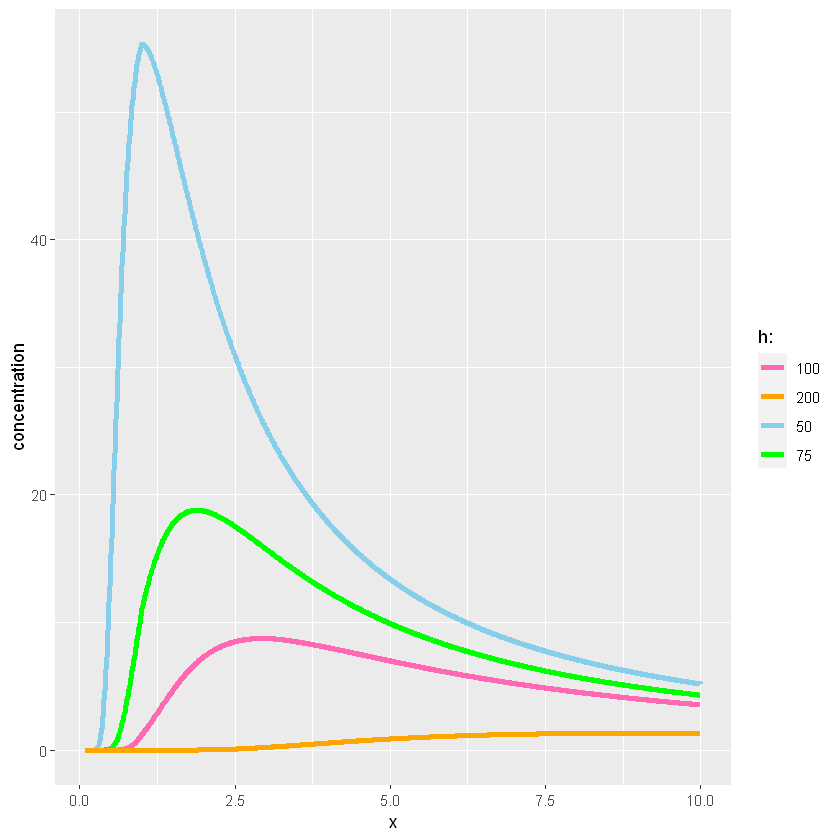

In [16]:
ggplot(df_h_cs, aes(x))+geom_line(aes(y=cs_50*10^6,col='50'),linewidth=1.5)+geom_line(aes(y=cs_75*10^6,col='75'),linewidth=1.5)+
    geom_line(aes(y=cs_100*10^6,col='100'),linewidth=1.5)+geom_line(aes(y=cs_200*10^6,col='200'),linewidth=1.5)+
    scale_color_manual(values = c('hotpink','orange','skyblue','green'))+guides(col=guide_legend(title="h:"))+
    ylab('concentration')

In [17]:
base <- data_wind[300,]
h <- c()
cond <- c()
for(i in 50:200){
    h <- c(h,rep(i,991))
    cond <- c(cond,gaussian_plume(base,h=i))
}

In [18]:
h_x_surface <- data.frame(rep(seq(.1,10,.01),151),h,cond)
colnames(h_x_surface) <- c('x','h','cs')

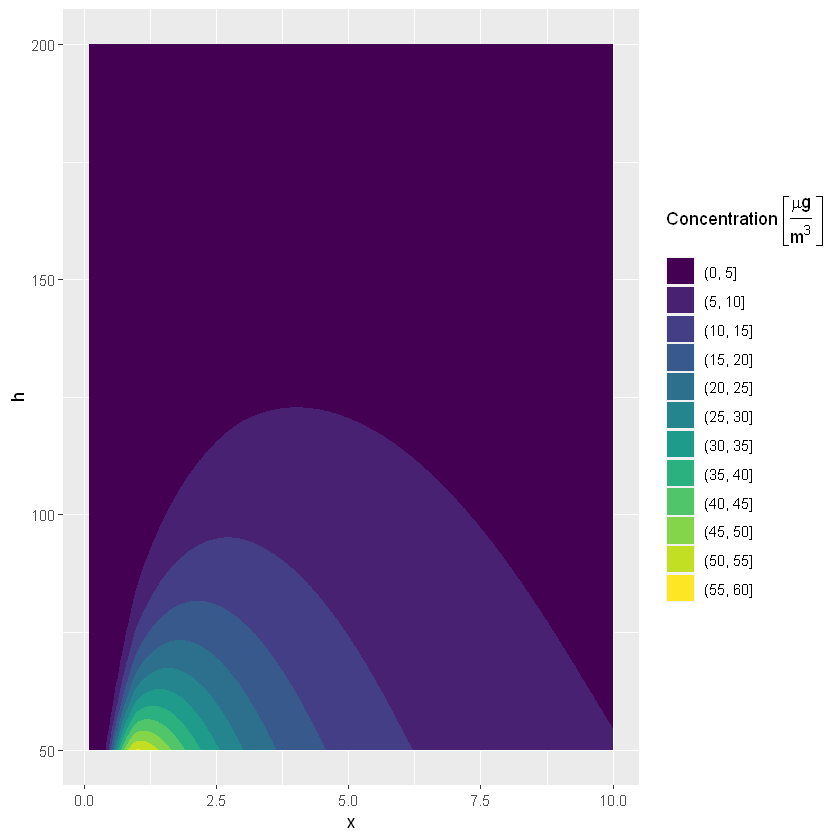

In [19]:
ggplot(h_x_surface, aes(x,h,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))

In [20]:
h <- c()
cond <- c()
for(i in 50:200){
    h <- c(h,rep(i,1000))
    cond <- c(cond,gaussian_plume(base,h=i,z=10,x_vec=seq(.01,10,.01)))
}
h_x_surface_10 <- data.frame(rep(seq(.01,10,.01),151),h,cond)
colnames(h_x_surface_10) <- c('x','h','cs')

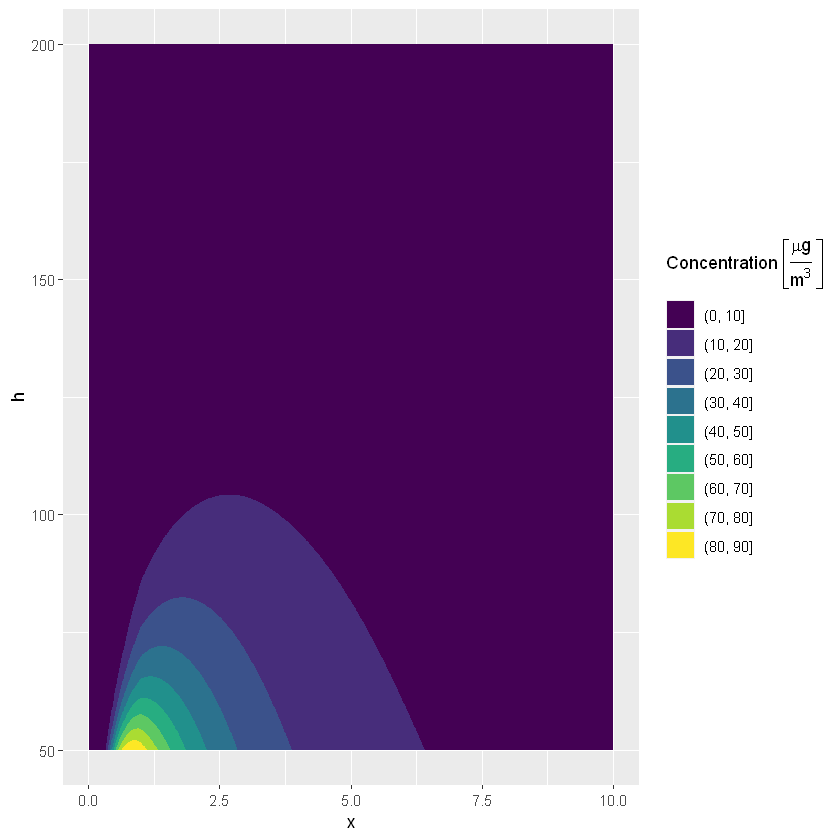

In [21]:
ggplot(h_x_surface_10, aes(x,h,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))

### Zobaczmy jak wygląda koncentracja dla stałych $y,h$ i zmiennych $x,z$.

In [22]:
z <- c()
condz <- c()
for(i in seq(0.1,10,.1)){
    z <- c(z,rep(i,length(seq(0.01,5,0.01))))
    condz <- c(condz,gaussian_plume(base,h=50,z=i, x_vec=seq(0.01,5,0.01)))
}

In [23]:
z_x_surface <- data.frame(rep(seq(0.01,5,0.01),length(seq(0.1,100,.1))),z,condz)
colnames(z_x_surface) <- c('x','z','cs')

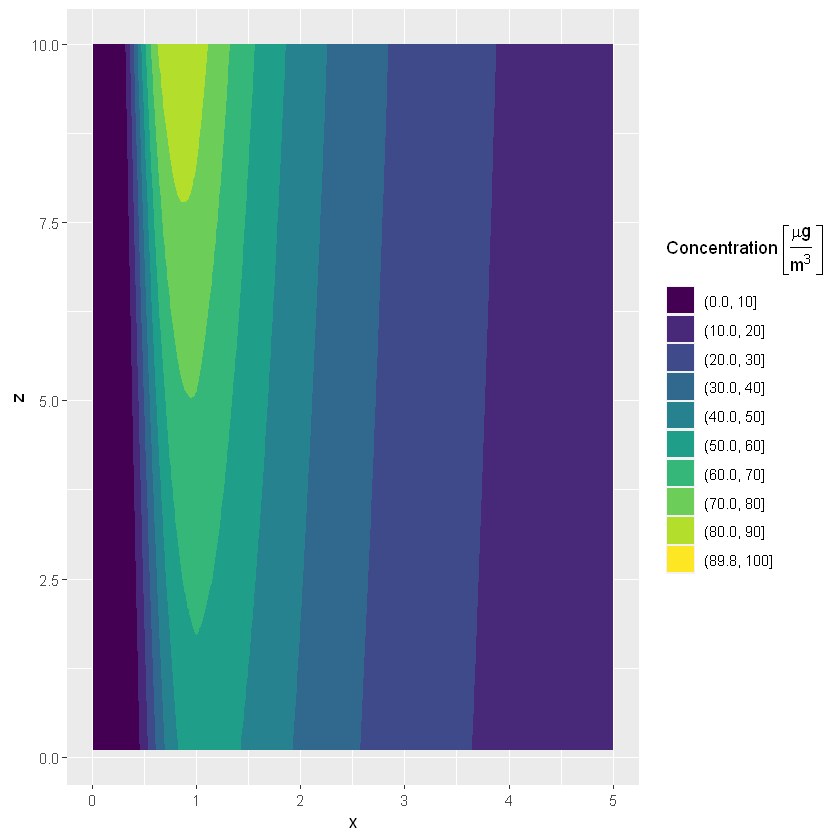

In [24]:
ggplot(z_x_surface, aes(x,z,z=cs*10^6))+geom_contour_filled(breaks=c(seq(0,100,10),10^6*max(z_x_surface$cs)))+
guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))

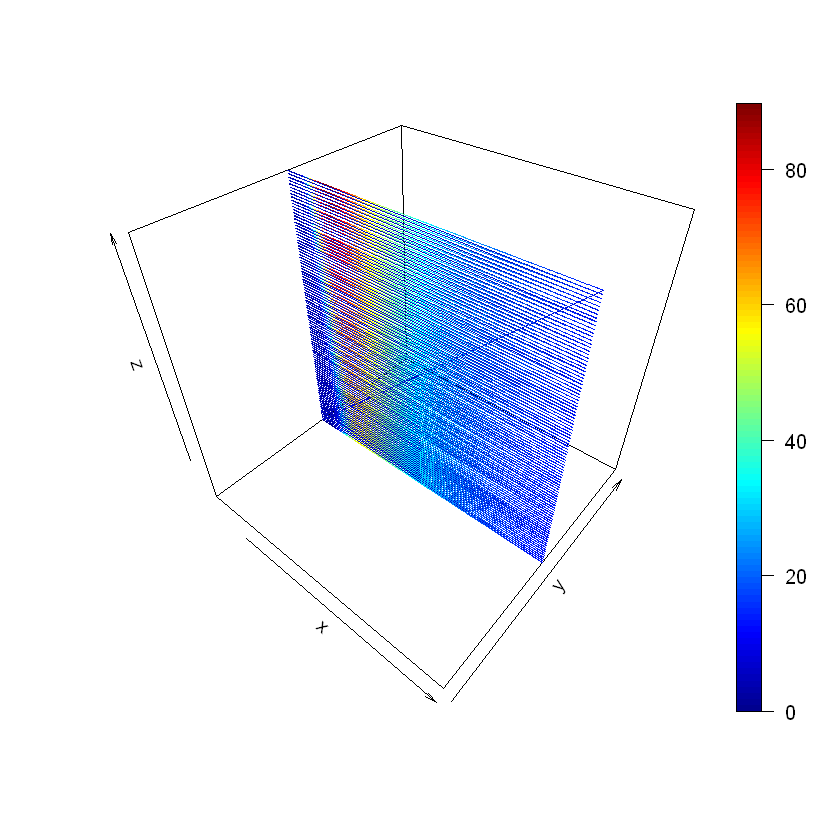

In [24]:
lines3D(z_x_surface$x, rep(0,length(z_x_surface$x)), (z_x_surface$z), colvar=z_x_surface$cs*10^6)

In [25]:
z <- c()
condz2 <- c()
for(i in seq(0,100,.01)){
    z <- c(z,rep(i,length(seq(0.1,3,0.1))))
    condz2 <- c(condz2,gaussian_plume(base,h=50,z=i, x_vec=seq(0.1,3,0.1), Q=1))
}

In [26]:
z_x_surface2 <- data.frame(rep(seq(0.1,3,0.1),length(seq(0,100,.01))),z,condz2)
colnames(z_x_surface2) <- c('x','z','cs')

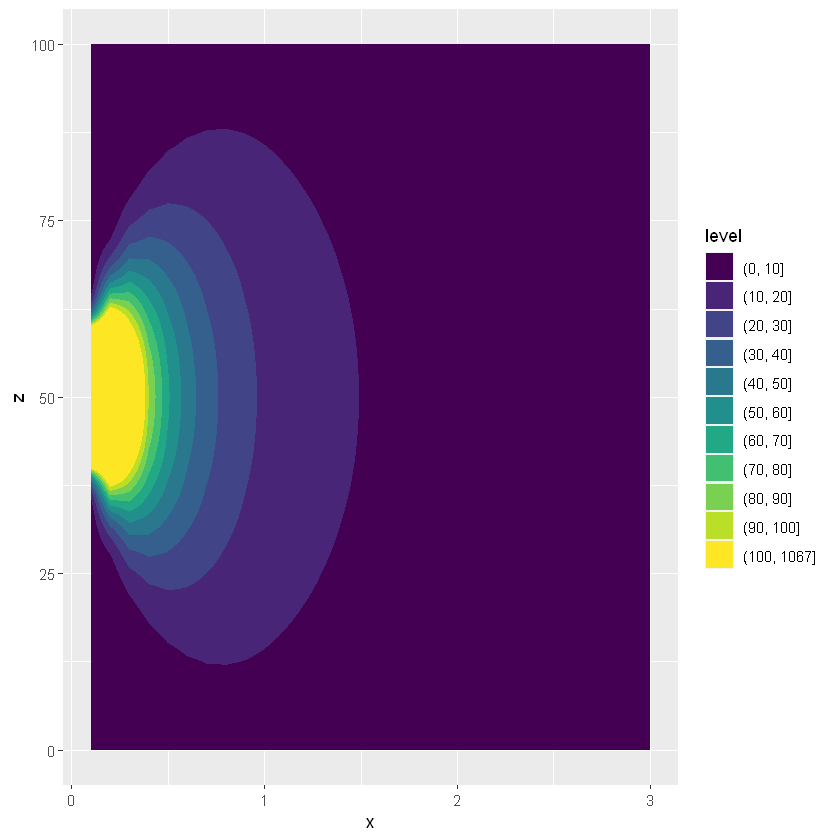

In [27]:
ggplot(z_x_surface2, aes(x,z,z=cs*10^6))+stat_contour_filled(breaks=c(seq(0,100,10),10^6*max(z_x_surface2$cs)))

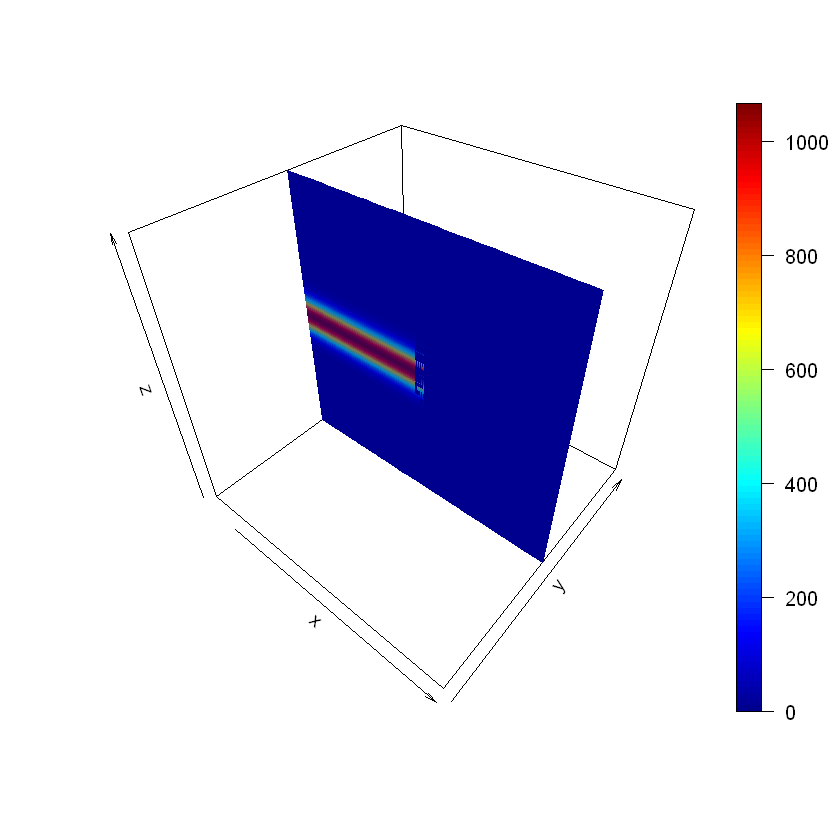

In [51]:
lines3D(z_x_surface2$x, rep(0,length(z_x_surface2$x)), (z_x_surface2$z), colvar=z_x_surface2$cs*10^6)

### Zobaczmy jak wygląda koncentracja dla stałych $z,h$ i zmiennych $x,y$.

In [28]:
y <- c()
condy <- c()
for(i in seq(-100,100,.1)){
    y <- c(y,rep(i,length(seq(0.1,3,0.1))))
    condy <- c(condy,gaussian_plume(base,h=50,y=i,z=10,x_vec=seq(0.1,3,0.1),Q=10))
}
y_x_surface <- data.frame(rep(seq(.1,3,.1),length(seq(-100,100,.1))),y,condy)
colnames(y_x_surface) <- c('x','y','cs')

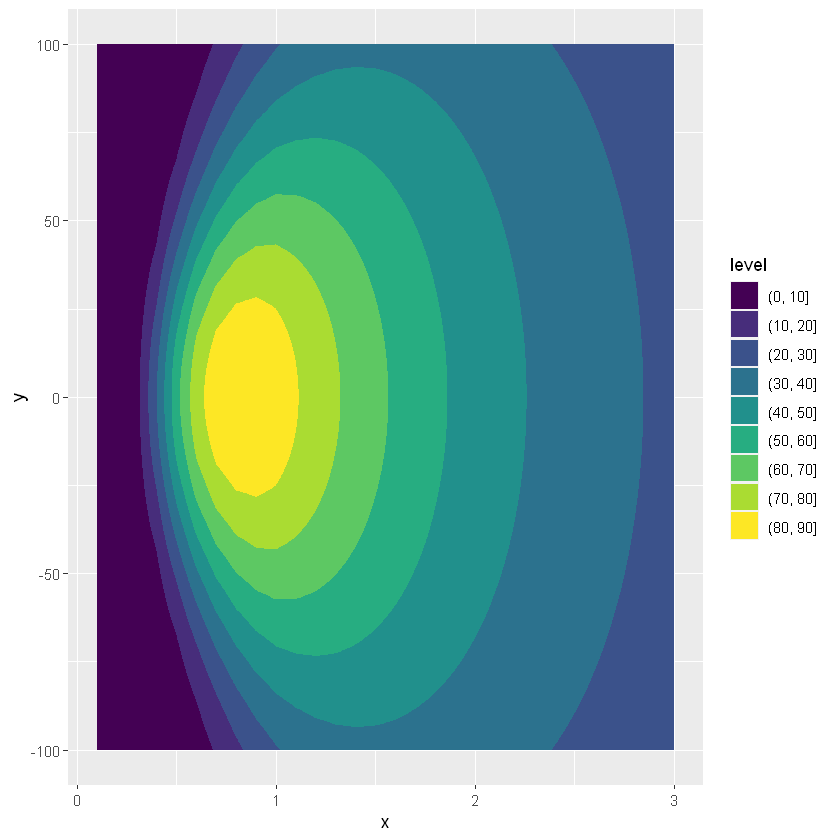

In [29]:
ggplot(y_x_surface, aes(x,y,z=cs*10^6))+geom_contour_filled()

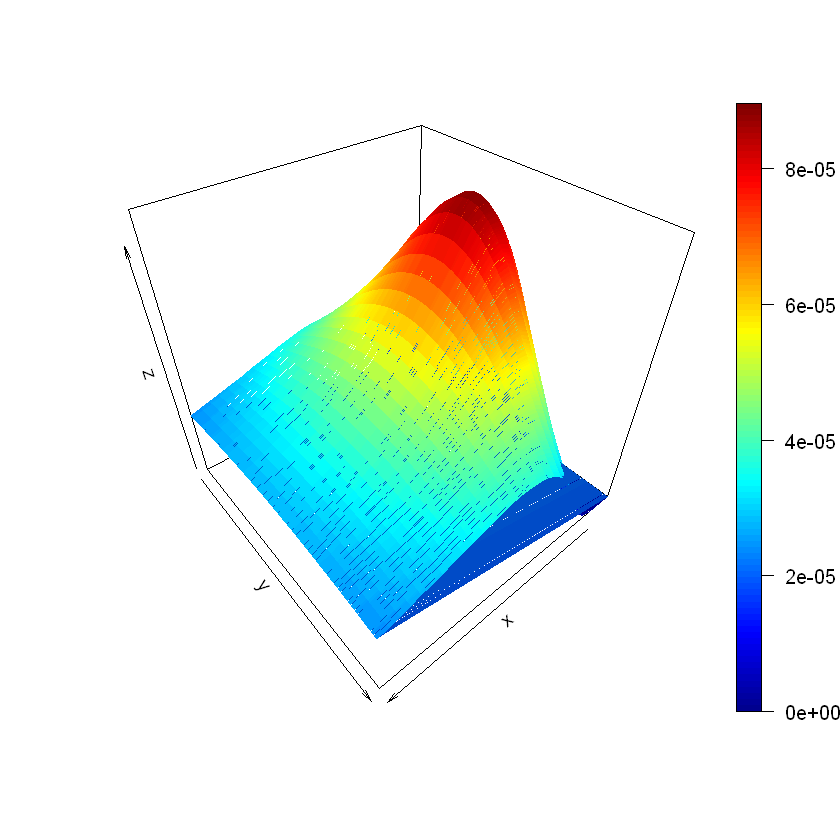

In [68]:
lines3D(y_x_surface$x, y_x_surface$y, y_x_surface$cs,theta=140)

In [30]:
cs_matrix <- matrix(y_x_surface$cs, 
                         nrow = 30, 
                         ncol = 2001)
x_3d <- seq(0.1,3,0.1)
y_3d <- seq(-100,100,.1)

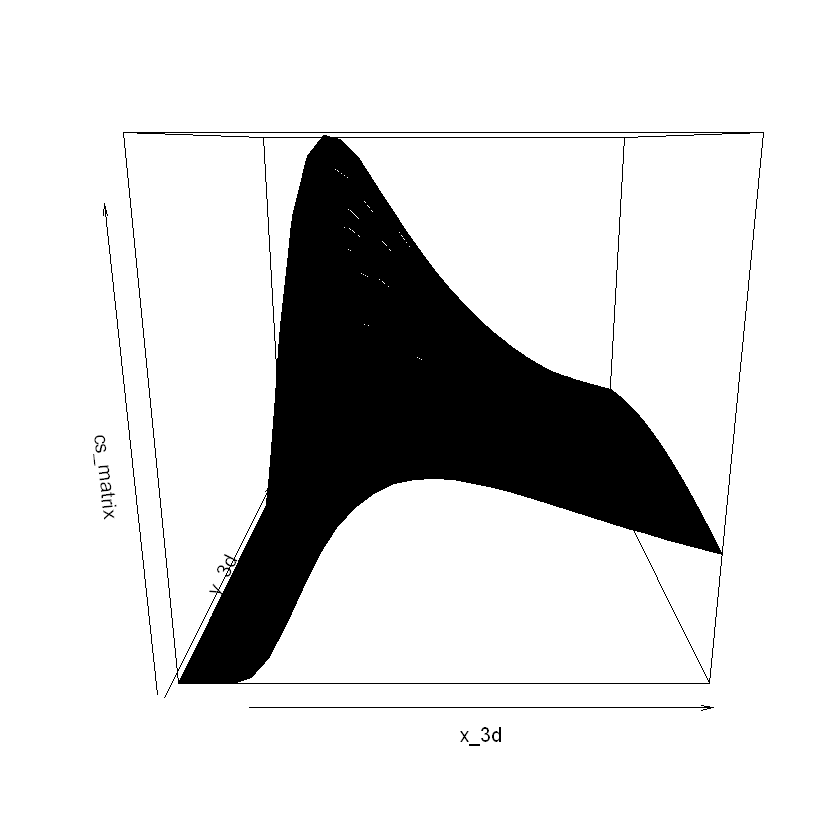

In [31]:
persp(x_3d, y_3d, cs_matrix)

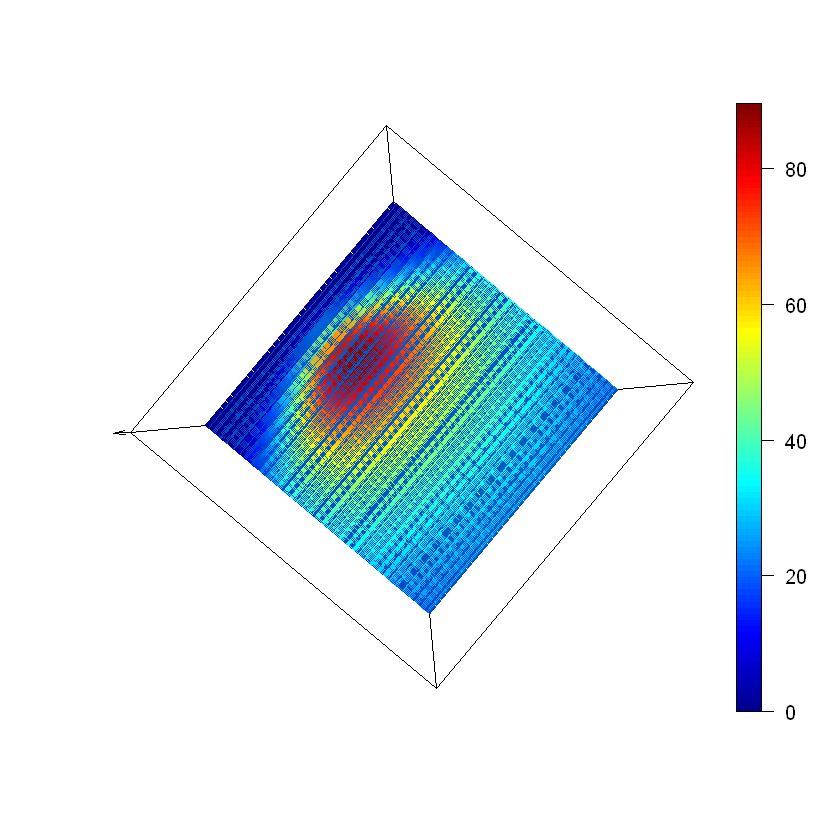

In [79]:
lines3D(y_x_surface$x, y_x_surface$y, rep(0,length(y_x_surface$x)), colvar=y_x_surface$cs*10^6, phi=90)

In [32]:
y <- c()
condy2 <- c()
for(i in seq(-50,50,.1)){
    y <- c(y,rep(i,length(seq(0.01,3,0.01))))
    condy2 <- c(condy2,gaussian_plume(base,h=10,y=i,z=1.6, x_vec=seq(0.01,3,0.01),Q=0.1))
}
y_x_surface2 <- data.frame(rep(seq(0.01,3,0.01),length(seq(-50,50,0.1))),y,condy2)
colnames(y_x_surface2) <- c('x','y','cs')

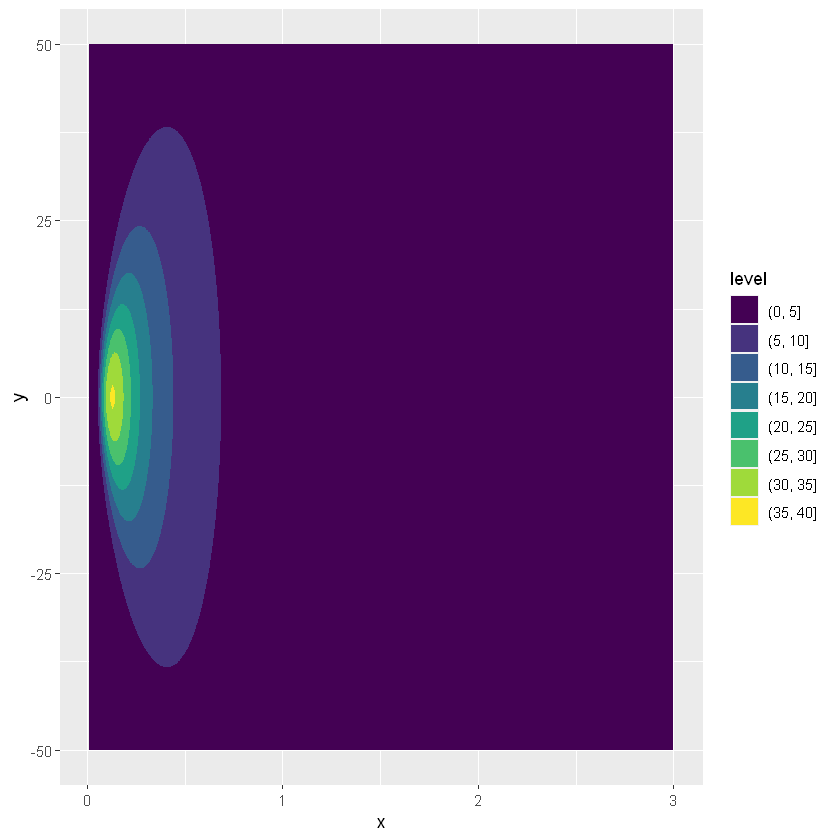

In [33]:
ggplot(y_x_surface2, aes(x,y,z=cs*10^6))+geom_contour_filled()

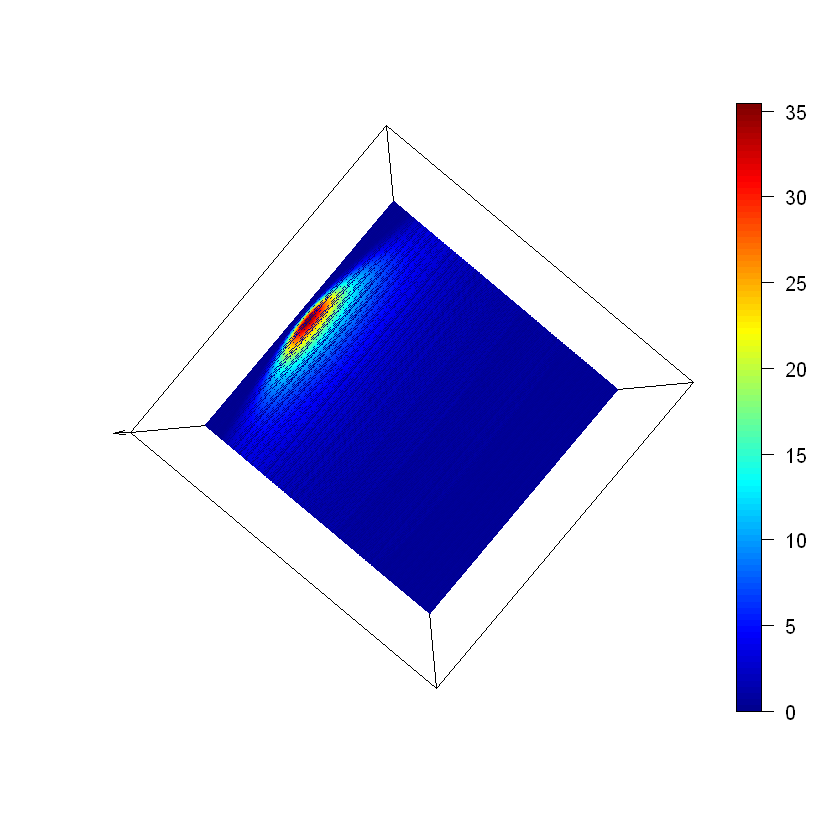

In [85]:
lines3D(y_x_surface2$x, y_x_surface2$y, rep(0,length(y_x_surface2$x)), colvar=y_x_surface2$cs*10^6, phi=90)

### Zobaczmy jak wygląda koncentracja dla stałego $h$ i zmiennych $x,y,z$.

In [34]:
y <- c()
z <- c()
condxyz <- c()
for(i in seq(-20,20,1)){
    y <- c(y,rep(i,length(seq(.01,3,.01))*length(seq(0,10,.1))))
    for(j in seq(0,10,.1)){
        z <- c(z,rep(j,length(seq(.01,3,.01))))
        condxyz <- c(condxyz,gaussian_plume(base,h=50,y=i,z=j, x_vec=seq(.01,3,.01),Q=30))
    }
}

In [35]:
surface1 <- data.frame(rep(seq(0.01,3,0.01),length(seq(-20,20,1))*length(seq(0,10,.1))),y,z,condxyz)
colnames(surface1) <- c('x','y','z','cs')

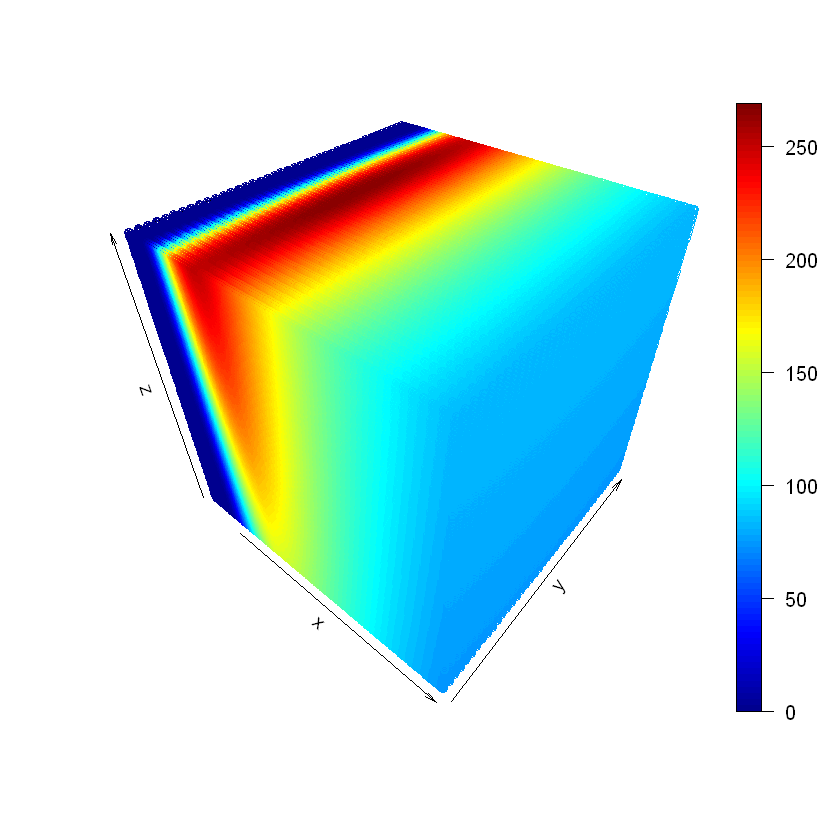

In [36]:
scatter3D(surface1$x, surface1$y, surface1$z,colvar = surface1$cs*10^6)

In [37]:
y <- c()
z <- c()
condxyz2 <- c()
for(i in seq(-20,20,1)){
    y <- c(y,rep(i,length(seq(.01,3,.01))*length(seq(0,20,.1))))
    for(j in seq(0,20,.1)){
        z <- c(z,rep(j,length(seq(.01,3,.01))))
        condxyz2 <- c(condxyz2,gaussian_plume(base,h=10,y=i,z=j, x_vec=seq(.01,3,.01),Q=0.1))
    }
}

In [38]:
surface2 <- data.frame(rep(seq(0.01,3,0.01),length(seq(-20,20,1))*length(seq(0,20,.1))),y,z,condxyz2)
colnames(surface2) <- c('x','y','z','cs')

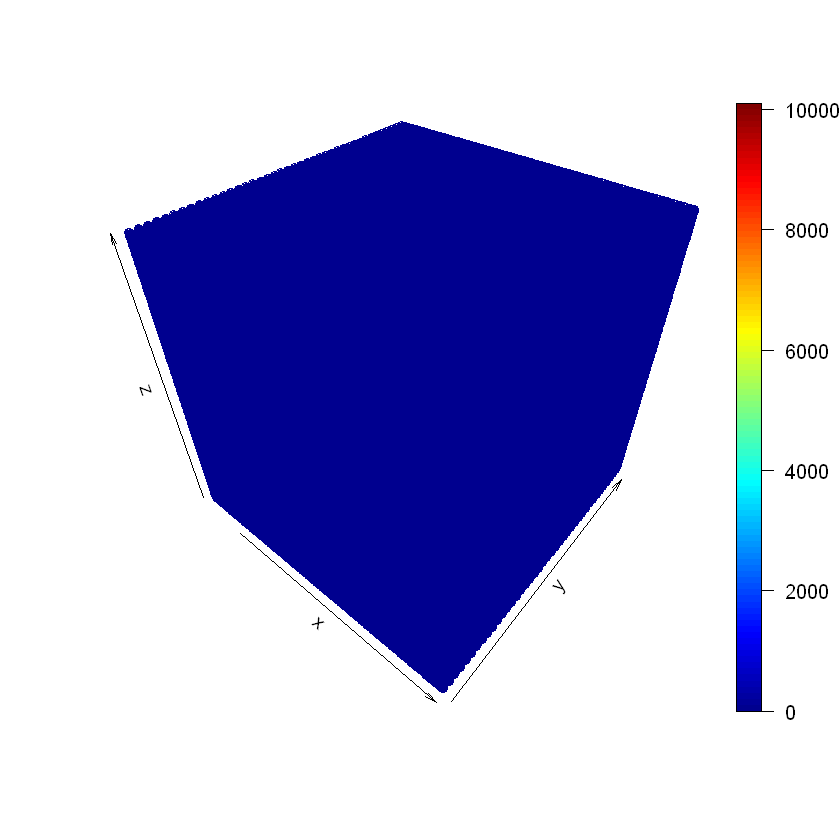

In [98]:
scatter3D(surface2$x, surface2$y, surface2$z,colvar = surface2$cs*10^6)

### Teraz spróbujemy pokazać kształt

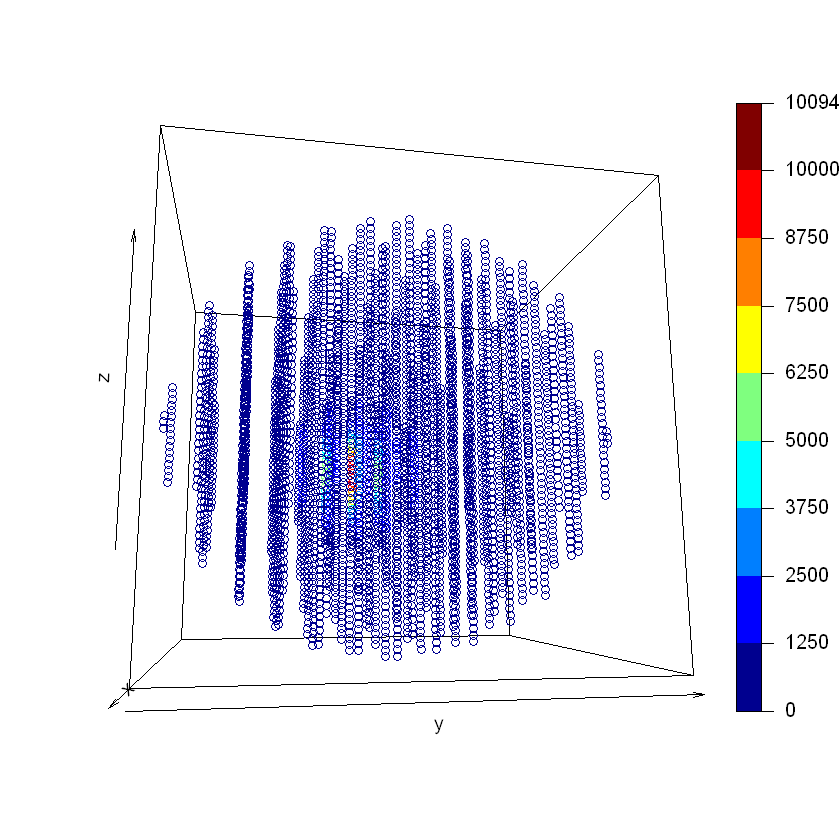

In [39]:
surface3 <- surface2[surface2$cs>2*10^(-4),]
scatter3D(surface3$x, surface3$y, surface3$z,colvar = surface3$cs*10^6, breaks=c(linspace(0,10000,9),max(surface3$cs)*10^6), theta=80, phi=350)

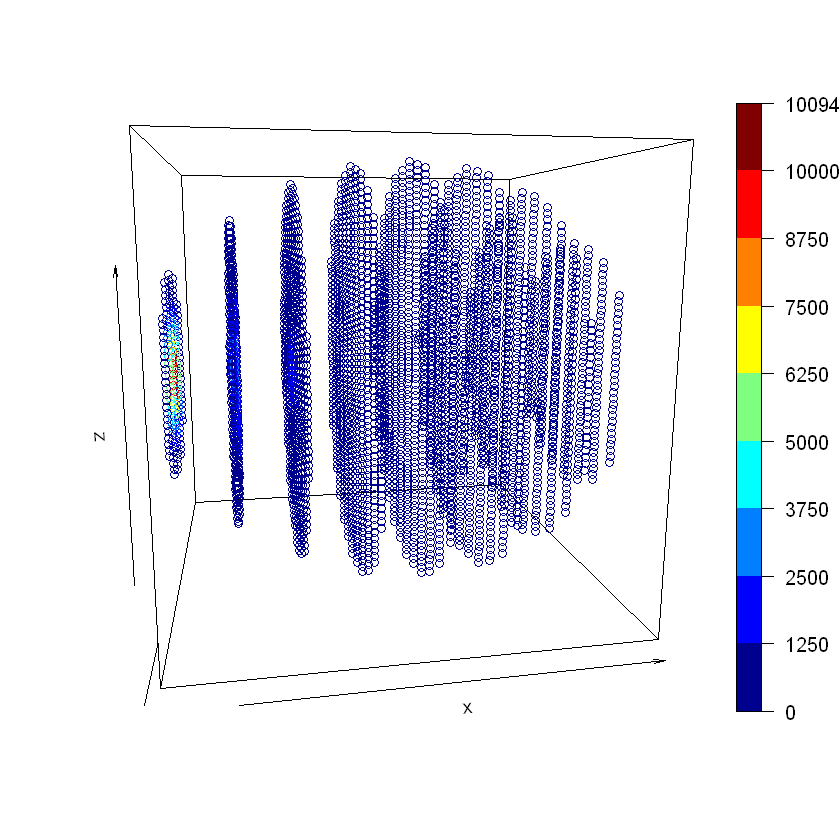

In [40]:
scatter3D(surface3$x, surface3$y, surface3$z,colvar = surface3$cs*10^6, breaks=c(linspace(0,10000,9),max(surface3$cs)*10^6),theta=350, phi=10)

In [41]:
yb <- c()
zb <- c()
condb <- c()
for(i in seq(-50,50,1)){
    yb <- c(yb,rep(i,length(seq(0.01,1,0.01))*length(seq(0,20,.1))))
    for(j in seq(0,20,.1)){
        zb <- c(zb,rep(j,length(seq(0.01,1,0.01))))
        condb <- c(condb,gaussian_plume(base,h=10,y=i,z=j, x_vec=seq(0.01,1,0.01),Q=10))
    }
}

In [42]:
surface4 <- data.frame(rep(seq(0.01,1,0.01),length(seq(-50,50,1))*length(seq(0,20,.1))),yb,zb,condb)
colnames(surface4) <- c('x','y','z','cs')

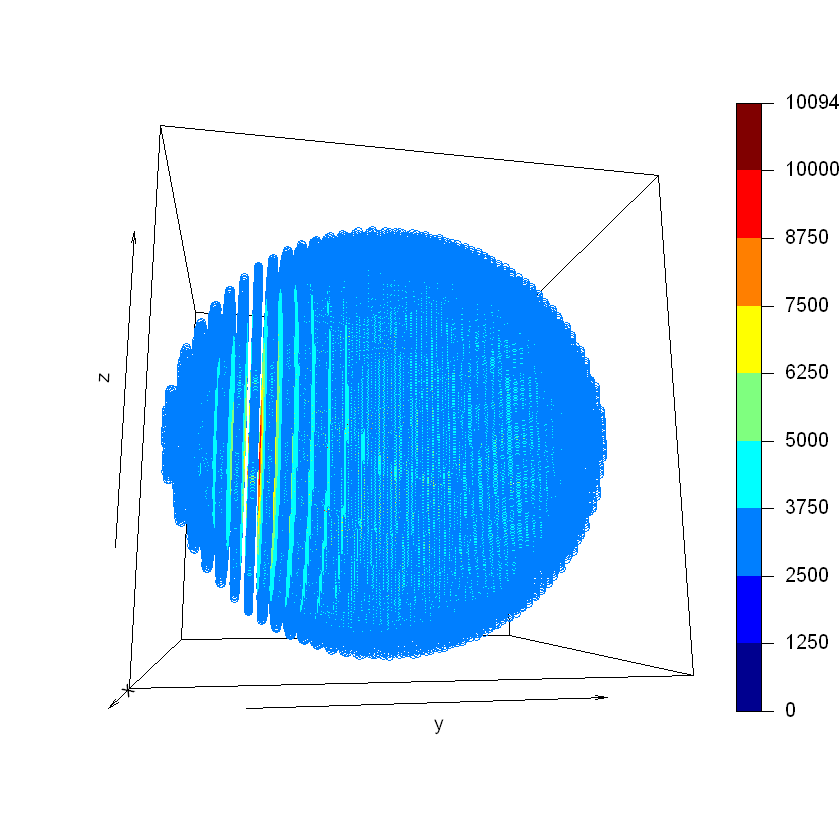

In [43]:
surface5 <- surface4[surface4$cs>3*10^(-3),]
scatter3D(surface5$x, surface5$y, surface5$z,colvar = surface5$cs*10^6, breaks=c(linspace(0,10000,9),max(surface5$cs)*10^6), theta=80, phi=350)

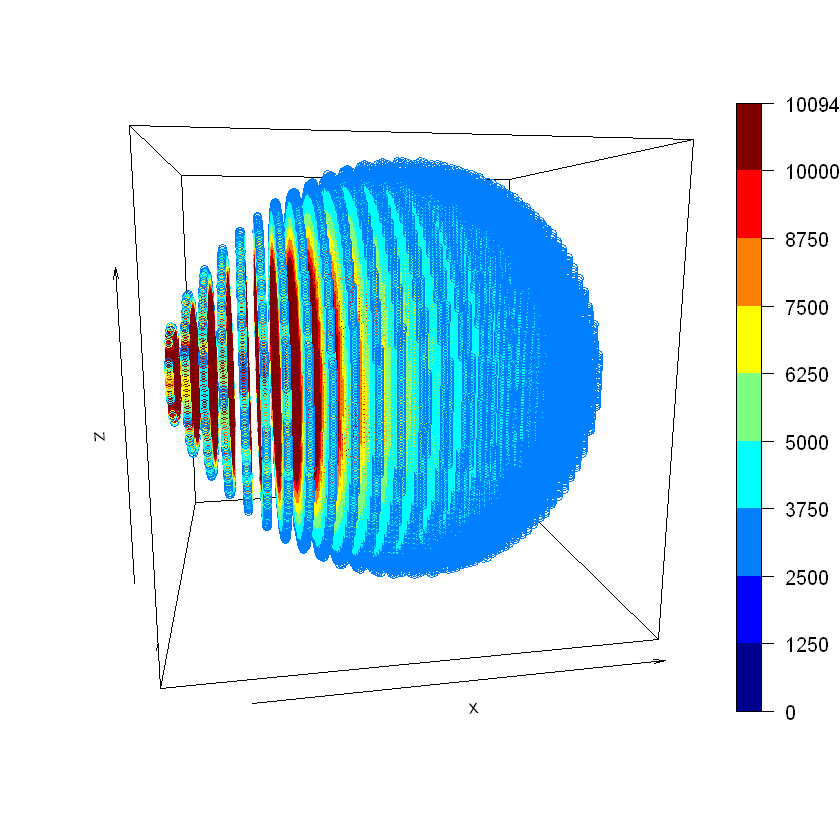

In [44]:
scatter3D(surface5$x, surface5$y, surface5$z,colvar = surface5$cs*10^6,breaks=c(linspace(0,10000,9),max(surface5$cs)*10^6),theta=350, phi=10)

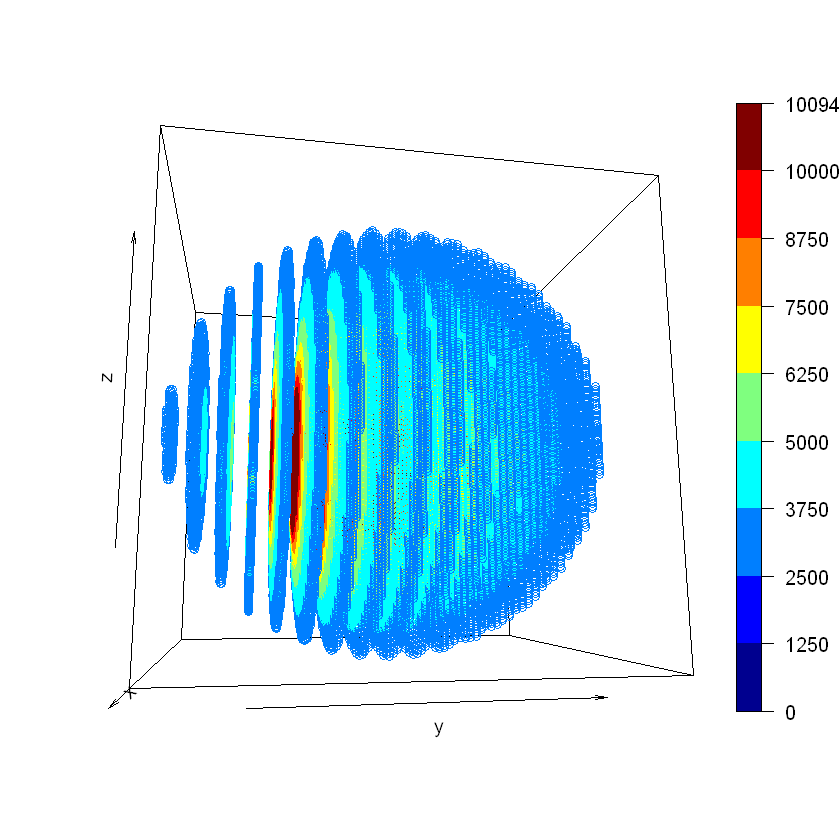

In [45]:
surface6 <- surface5[mod(surface5$y,2)==0,]
scatter3D(surface6$x, surface6$y, surface6$z,colvar = surface6$cs*10^6, breaks=c(linspace(0,10000,9),max(surface6$cs)*10^6), theta=80, phi=350)

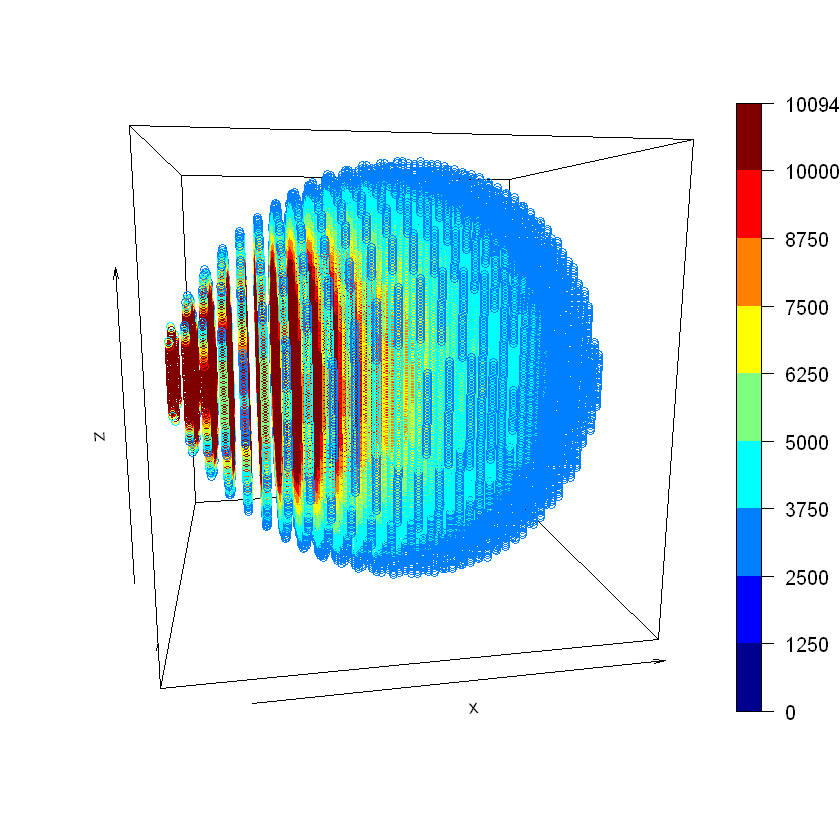

In [46]:
scatter3D(surface6$x, surface6$y, surface6$z,colvar = surface6$cs*10^6,breaks=c(linspace(0,10000,9),max(surface6$cs)*10^6),theta=350, phi=10)

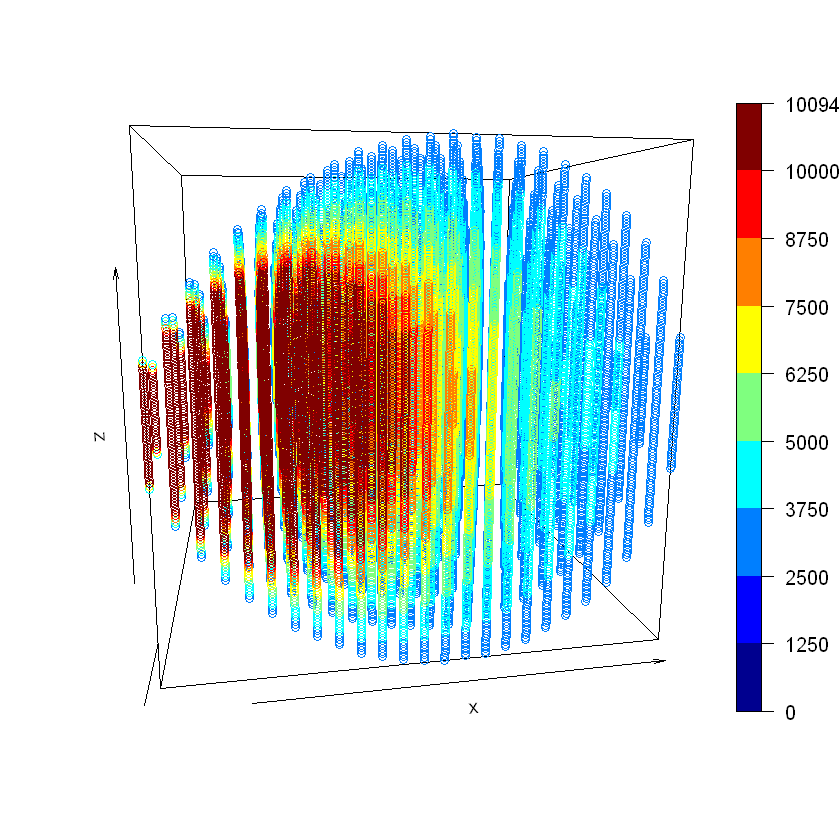

In [47]:
surface7 <- surface6[surface6$y>=0,]
scatter3D(surface7$x, surface7$y, surface7$z,colvar = surface7$cs*10^6, breaks=c(linspace(0,10000,9),max(surface7$cs)*10^6), theta=350, phi=10)

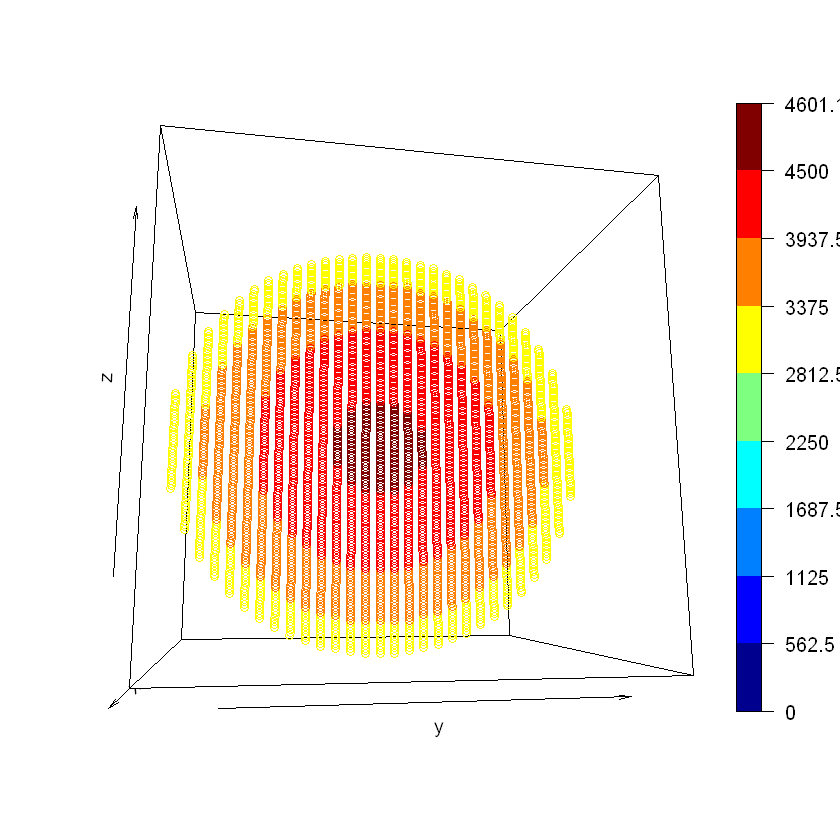

In [48]:
surface8 <- surface5[surface5$x==0.2,]
scatter3D(surface8$x, surface8$y, surface8$z,colvar = surface8$cs*10^6, breaks=c(linspace(0,4500,9),max(surface8$cs)*10^6), theta=80, phi=350)

In [49]:
7.5*10^3*10^6/365/24/60/60

[1] 237.8234